<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/01_measuring_text_similarities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Measuring text similarities

In this notebook, we focus on a basic NLP problem: **measuring the similarity between two texts**. 

We will quickly discover a feasible solution that is not computationally efficient.
We will then explore a series of numerical techniques for rapidly computing
text similarities.

##Setup

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

##Simple text comparison

Suppose we want to compare three simple texts:

```text
text1—She sells seashells by the seashore
text2—“Seashells! The seashells are on sale! By the seashore.”
text3—She sells 3 seashells to John, who lives by the lake.
```

Our goal is to determine whether `text1` is more similar to `text2` or to `text3`.



In [18]:
# Assigning texts to variables
text1 = "She sells seashells by the seashore."
text2 = '"Seashells! The seashells are on sale! By the seashore."'
text3 = "She sells 3 seashells to John, who lives by the lake."

Now we need to quantify the differences between texts.

In [19]:
# Splitting texts into words
words_lists = [text.split() for text in [text1, text2, text3]]
words1, words2, words3 = words_lists

for i, words in enumerate(words_lists, 1):
  print(f"Words in text {i}")
  print(f"{words}\n")

Words in text 1
['She', 'sells', 'seashells', 'by', 'the', 'seashore.']

Words in text 2
['"Seashells!', 'The', 'seashells', 'are', 'on', 'sale!', 'By', 'the', 'seashore."']

Words in text 3
['She', 'sells', '3', 'seashells', 'to', 'John,', 'who', 'lives', 'by', 'the', 'lake.']



In [20]:
# Removing case sensitivity and punctuation
def simplify_text(text):
  for punctuation in ['.', ',', '!', '?', '"']:
    text = text.replace(punctuation, "")
  return text.lower()

In [21]:
for i, words in enumerate(words_lists, 1):
  for j, word in enumerate(words):
    words[j] = simplify_text(word)
  print(f"Words in text {i}")
  print(f"{words}\n")

Words in text 1
['she', 'sells', 'seashells', 'by', 'the', 'seashore']

Words in text 2
['seashells', 'the', 'seashells', 'are', 'on', 'sale', 'by', 'the', 'seashore']

Words in text 3
['she', 'sells', '3', 'seashells', 'to', 'john', 'who', 'lives', 'by', 'the', 'lake']



In [22]:
# Converting word lists to sets
words_sets = [set(words) for words in words_lists]
for i, unique_words in enumerate(words_sets, 1):
  print(f"Unique Words in text {i}")
  print(f"{unique_words}\n")

Unique Words in text 1
{'the', 'seashore', 'she', 'seashells', 'sells', 'by'}

Unique Words in text 2
{'sale', 'on', 'the', 'are', 'seashore', 'by', 'seashells'}

Unique Words in text 3
{'john', 'lake', '3', 'the', 'to', 'she', 'by', 'lives', 'who', 'sells', 'seashells'}



In [23]:
# Extracting overlapping words between two texts
words_set1 = words_sets[0]
for i, words_set in enumerate(words_sets[1:], 2):
  shared_words = words_set1 & words_set
  print(f"Texts 1 and {i} share these {len(shared_words)} words:")
  print(f"{shared_words}\n")

Texts 1 and 2 share these 4 words:
{'seashore', 'by', 'seashells', 'the'}

Texts 1 and 3 share these 5 words:
{'the', 'she', 'seashells', 'sells', 'by'}



In [24]:
# Extracting diverging words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  diverging_words = words_set1 ^ words_set
  print(f"Texts 1 and {i} don't share these {len(diverging_words)} words:")
  print(f"{diverging_words}\n")

Texts 1 and 2 don't share these 5 words:
{'sale', 'on', 'are', 'she', 'sells'}

Texts 1 and 3 don't share these 7 words:
{'john', 'lake', '3', 'to', 'seashore', 'lives', 'who'}



To combine their overlap and divergence into a single similarity score, we must first combine all overlapping
and diverging words between the texts. 

This aggregation, which is called a union, will
contain all the unique words across the two texts.

In [25]:
# Extracting the union of words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  total_words = words_set1 | words_set
  print(f"Together, texts 1 and {i} contain {len(total_words)} unique words. These words are:\n {total_words}\n")

Together, texts 1 and 2 contain 9 unique words. These words are:
 {'sale', 'on', 'the', 'are', 'seashore', 'she', 'seashells', 'sells', 'by'}

Together, texts 1 and 3 contain 12 unique words. These words are:
 {'the', 'to', 'lives', 'who', 'seashells', 'john', 'lake', '3', 'seashore', 'she', 'sells', 'by'}



Accordingly, both overlap and divergence represent complementary
percentages of the total unique word count across texts.

In [26]:
# Extracting the percentage of shared words between two texts
for i, words_set in enumerate(words_sets[1:], 2):
  shared_words = words_set1 & words_set
  diverging_words = words_set1 ^ words_set
  total_words = words_set1 | words_set
  assert len(total_words) == len(shared_words) + len(diverging_words)

  # Percent of total words shared with text 1
  percent_shared = 100 * len(shared_words) / len(total_words)
  # Percent of total words that diverge from text 1 
  percent_diverging = 100 * len(diverging_words) / len(total_words)

  print(f"Together, texts 1 and {i} contain {len(total_words)} unique words. \n{percent_shared:.2f}% of these words are shared.\n{percent_diverging:.2f}% of these words diverge.\n")

Together, texts 1 and 2 contain 9 unique words. 
44.44% of these words are shared.
55.56% of these words diverge.

Together, texts 1 and 3 contain 12 unique words. 
41.67% of these words are shared.
58.33% of these words diverge.



We’ve essentially developed a simple metric for assessing similarities between texts.

This similarity metric is referred to as the Jaccard similarity, or the Jaccard index.

##Exploring the Jaccard similarity

The Jaccard similarity is a reasonable measure of text resemblance for the following reasons:

* The similarity takes into account both text overlap and text divergence.
* The fractional similarity is always between 0 and 1. The fraction is easy to interpret: 0 indicates that no words are shared, 0.5 indicates that half the words are shared, and 1 indicates that all the words are shared.
* The similarity is simple to implement.

In [27]:
# Computing the Jaccard similarity
def jaccard_similarity(text_a, text_b):
  word_set_a, word_set_b = [set(simplify_text(text).split()) for text in [text_a, text_b]]
  num_shared = len(word_set_a & word_set_b)
  num_total = len(word_set_a | word_set_b)
  return num_shared / num_total

In [28]:
for text in [text2, text3]:
  similarity = jaccard_similarity(text1, text)
  print(f"Text comparison:\n\t{text1}\n\t{text}\nThe Jaccard similarity is {similarity:.2f}\n")

Text comparison:
	She sells seashells by the seashore.
	"Seashells! The seashells are on sale! By the seashore."
The Jaccard similarity is 0.44

Text comparison:
	She sells seashells by the seashore.
	She sells 3 seashells to John, who lives by the lake.
The Jaccard similarity is 0.42



In [29]:
# Efficiently computing the Jaccard similarity
def jaccard_similarity_efficient(text_a, text_b):
  word_set_a, word_set_b = [set(simplify_text(text).split()) for text in [text_a, text_b]]
  num_shared = len(word_set_a & word_set_b)
  num_total = len(word_set_a) + len(word_set_b) - num_shared
  return num_shared / num_total

In [30]:
for text in [text2, text3]:
  similarity = jaccard_similarity_efficient(text1, text)
  assert similarity == jaccard_similarity(text1, text)
  print(f"Text comparison:\n\t{text1}\n\t{text}\nThe Jaccard similarity is {similarity:.2f}\n")

Text comparison:
	She sells seashells by the seashore.
	"Seashells! The seashells are on sale! By the seashore."
The Jaccard similarity is 0.44

Text comparison:
	She sells seashells by the seashore.
	She sells 3 seashells to John, who lives by the lake.
The Jaccard similarity is 0.42



##Replacing words with numeric values

The mapping between words
and their numeric values can be stored in a Python dictionary. We’ll refer to this dictionary
as our vocabulary. 

Let’s build a vocabulary that covers all the words in our three
texts.

In [31]:
# Assigning words to numbers in a vocabulary
words_set1, words_set2, words_set3 = words_sets
total_words = words_set1 | words_set2 | words_set3
vocabulary = {word: i for i, word in enumerate(total_words)}
value_to_word = {value: word for word, value in vocabulary.items()}
print(f"Our vocabulary contains {len(vocabulary)} words. This vocabulary is:\n{vocabulary}")

Our vocabulary contains 15 words. This vocabulary is:
{'on': 0, 'the': 1, 'are': 2, 'to': 3, 'lives': 4, 'who': 5, 'seashells': 6, 'john': 7, 'lake': 8, 'sale': 9, '3': 10, 'seashore': 11, 'she': 12, 'sells': 13, 'by': 14}


Given our vocabulary, we can convert any text into a one-dimensional array of numbers.

Mathematically, a 1D numeric array is called a vector. 

Hence, the process of converting
text into a vector is called text vectorization.

Let’s use binary vectorization to convert all texts into NumPy arrays.

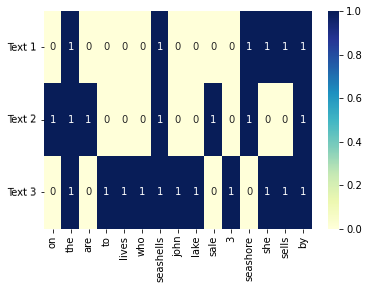

In [33]:
# Transforming words into binary vectors
vectors = []
for i, words_set in enumerate(words_sets, 1):
  # Generates an array of 0s
  vector = np.array([0] * len(vocabulary))
  for word in words_set:
    vector[vocabulary[word]] = 1
  vectors.append(vector)

sns.heatmap(vectors, annot=True, cmap="YlGnBu", 
             xticklabels=vocabulary.keys(),
             yticklabels=["Text 1", "Text 2", "Text 3"])
plt.yticks(rotation=1)
plt.show()

Our binary vector representation allows us to extract shared words numerically.

In [34]:
# Finding shared words using vector arithmetic
vector1, vector2 = vectors[:2]
for i in range(len(vocabulary)):
  if vector1[i] * vector2[i]:
    shared_word = value_to_word[i]
    print(f"'{shared_word}' is present in both texts 1 and 2")

'the' is present in both texts 1 and 2
'seashells' is present in both texts 1 and 2
'seashore' is present in both texts 1 and 2
'by' is present in both texts 1 and 2


In [35]:
# Counting shared words using vector arithmetic
shared_word_count = sum(vector1[i] * vector2[i] for i in range(len(vocabulary)))
assert shared_word_count == len(words_set1 & words_set2)

The sum of the pairwise products across all vector indices is called the dot product.

In [36]:
# Computing a vector dot product using NumPy
assert vector1.dot(vector2) == shared_word_count
assert vector1 @ vector2 == shared_word_count

Stated more concisely, `vector1 @ vector1` should equal the number of unique words
in `text1`, which is also equal to `len(words_set1)`. 

Let’s confirm.

In [37]:
assert vector1 @ vector1 == len(words_set1)
assert vector2 @ vector2 == len(words_set2)

Essentially, we can compute the Jaccard similarity using only
vector operations. 

This vectorized implementation of Jaccard is called the Tanimoto
similarity.

In [38]:
# Computing text similarity using vector arithmetic
def tanimoto_similarity(vector_a, vector_b):
  num_shared = vector_a @ vector_b
  num_total = vector_a @ vector_a + vector_b @ vector_b - num_shared
  return num_shared / num_total

In [40]:
for i, text in enumerate([text2, text3], 1):
  similarity = tanimoto_similarity(vector1, vectors[i])
  assert similarity == jaccard_similarity(text1, text)

What
would happen if we inputted two arrays with values other than 0 or 1? 

Technically,
the function should return a similarity, but would that similarity make sense? 

For
instance, vectors `[5, 3]` and `[5, 2]` are nearly identical. We expect their similarity to be nearly equal to 1.

Let’s test our expectations by inputting the vectors.

In [41]:
# Computing the similarity of non-binary vectors
non_binary_vector1 = np.array([5, 3])
non_binary_vector2 = np.array([5, 2])

similarity = tanimoto_similarity(non_binary_vector1, non_binary_vector2)
print(f"The similarity of 2 non-binary vectors is {similarity}")

The similarity of 2 non-binary vectors is 0.96875


The outputted value is nearly equal to 1. 

Thus, `tanimoto_similarity` has successfully
measured the similarity between two nearly identical vectors. The function can analyze
non-binary inputs. 

This means we can use non-binary techniques to vectorize our
texts before comparing their contents.

##Vectorizing texts using word counts